In [1]:
import os
parent_dir = os.path.split(os.getcwd())[0]
%cd {parent_dir}

/home/chickencurry/diffusion-vi-neural-processes/neural-process/code


In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
from metalearning_benchmarks.sinusoid1d_benchmark import Sinusoid1D

from adapter import MetaLearningBenchmarkDatasetAdapter
from np import NeuralProcess
from train import train
from utils import split_context_target
from visualize import (sample_latent_space, visualize_batch_1d, visualize_decoder,
                       visualize_latent_space, visualize_losses)

In [3]:
device = None

try:
    import torch_directml
    device = torch_directml.device()
except ModuleNotFoundError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
print(device)

privateuseone:0


In [4]:
benchmark = Sinusoid1D(
    n_task=2048,
    n_datapoints_per_task=128,
    output_noise=0.01,
    seed_task=1235, 
    seed_x=123, 
    seed_noise=1237
)

dataset = MetaLearningBenchmarkDatasetAdapter(benchmark)
dataloader = DataLoader(dataset=dataset, batch_size=128, shuffle=True, num_workers=10)
gen_dataloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True, num_workers=10)

Generating tasks:   0%|          | 0/2048 [00:00<?, ?it/s]

Generating tasks: 100%|██████████| 2048/2048 [00:00<00:00, 177415.67it/s]


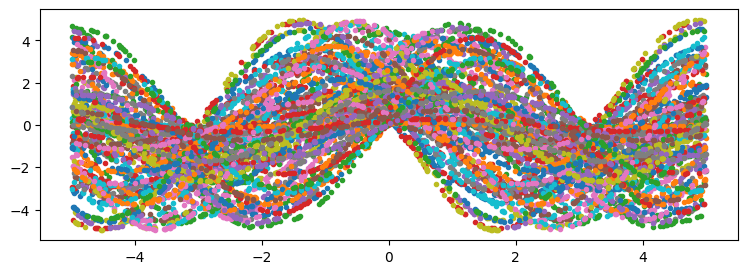

torch.Size([128, 128, 1])


In [5]:
visualize_batch_1d(batch=next(iter(dataloader)))
print(next(iter(dataloader))[0].shape)

In [13]:
model = NeuralProcess(x_dim=1, y_dim=1, r_dim=8, z_dim=8, h_dim=64).to(device)
# model.load_state_dict(torch.load('models/np.pth'))

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
recon_criterion = nn.MSELoss(reduction='mean')

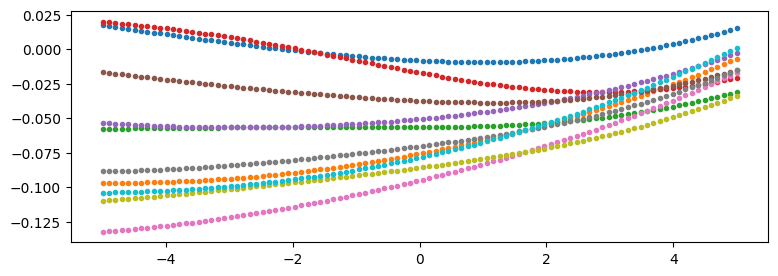

In [14]:
visualize_decoder(model=model, device=device, z_dim=8)

In [8]:
total_recon_losses = []
total_kl_divs = []

In [9]:
recon_losses, kl_divs = train(
    model=model, 
    device=device, 
    dataloader=dataloader, 
    optimizer=optimizer, 
    recon_criterion=recon_criterion, 
    num_epochs=80
)

total_recon_losses.extend(recon_losses)
total_kl_divs.extend(kl_divs)

  0%|          | 0/16 [00:00<?, ?it/s, epoch=0, factor=0.1, kl_div=0.00129, loss=4.41, recon_loss=4.41]/home/chickencurry/miniconda3/envs/directml/lib/python3.11/site-packages/torch/optim/adam.py:522: UserWarning: The operator 'aten::_foreach_lerp_.Scalar' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /__w/1/s/pytorch-directml-plugin/torch_directml/csrc/dml/dml_cpu_fallback.cpp:15.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)
100%|██████████| 16/16 [00:01<00:00, 10.22it/s, epoch=79, factor=0.419, kl_div=0.135, loss=0.502, recon_loss=0.367] 


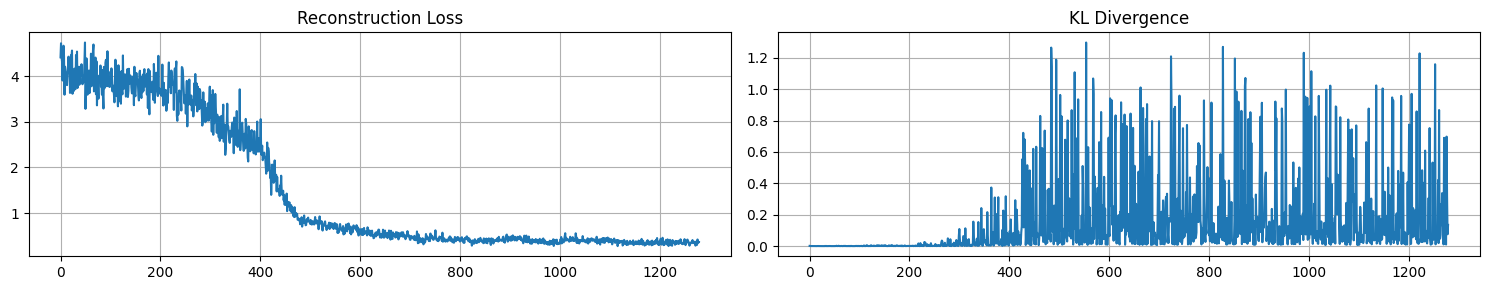

In [10]:
visualize_losses(recon_losses=recon_losses, kl_divs=kl_divs)

In [11]:
mus, logvars = sample_latent_space(model=model, device=device, dataloader=gen_dataloader, num_samples=1000)

1001it [00:02, 428.81it/s]                         


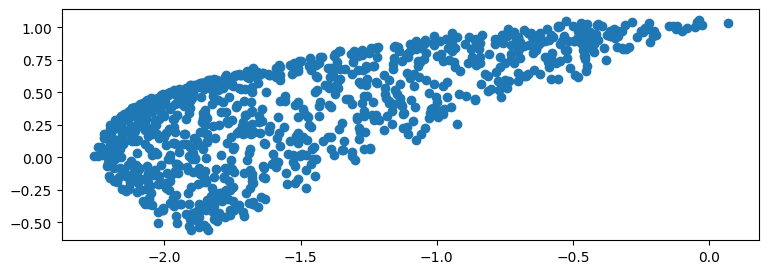

In [13]:
visualize_latent_space(
    mus=mus, 
    logvars=logvars, 
    dim_1=0, 
    dim_2=1
)

torch.Size([1, 116, 1])
torch.Size([1, 116, 2])


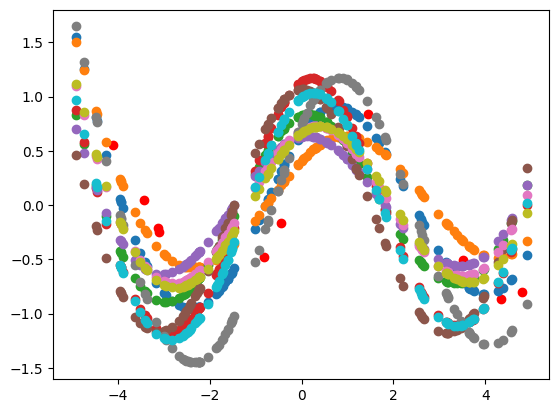

In [17]:
sample = next(iter(gen_dataloader))
sequence = torch.cat(sample, dim=-1).to(device)
factor = 0.1 # max(min(0.9, np.random.random()), 0.1)
context, target = split_context_target(sequence, factor)

n_samples = 10

mus, logvars, _, _ = model.sample(context, target[:, :, 0:1], n_samples)
print(mus[0].shape)
print(target.shape)
plt.scatter(context[0, :, 0].cpu().detach().numpy(), context[0, :, 1].cpu().detach().numpy(), c="red")

for i in range(n_samples):
    x = target[0, :, 0].cpu().detach().numpy()
    y = mus[i][0, :, 0].cpu().detach().numpy()
    plt.scatter(x, y)

plt.show()

In [77]:
torch.save(model.state_dict(), 'models/np.pth')